In [40]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

os.chdir('../')

from tgmm import GaussianMixture, GMMInitializer, dynamic_figsize, plot_gmm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
random_state = 42
np.random.seed(random_state)
torch.manual_seed(random_state)

if device == 'cuda':
    torch.cuda.manual_seed(random_state)
    print('CUDA version:', torch.version.cuda)
    print('Device:', torch.cuda.get_device_name(0))
else:
    print('Using CPU')

CUDA version: 12.4
Device: NVIDIA GeForce RTX 4060 Laptop GPU


In [41]:
n_samples = [1000, 1000, 1000, 1000]
centers = [np.array([0, 2]),
           np.array([3, 4]),
           np.array([5, 3]),
           np.array([0, 6])]
covs = [
    np.array([[.8, .1], [0, .5]]),    # full covariance
    np.array([[.2, .4], [0, .5]]),    # full covariance
    np.array([[.4, .3], [0, .5]]),    # full covariance
    np.array([[.6, .2], [0, .5]])    # full covariance
]

components = []
for n, center, cov in zip(n_samples, centers, covs):
    samples = np.dot(np.random.randn(n, 2), cov) + center
    components.append(samples)

X = np.vstack(components)
labels = np.concatenate([i * np.ones(n) for i, n in enumerate(n_samples)])
legend_labels = [f'Component {i+1}' for i in range(len(n_samples))]

n_features = X.shape[1]
n_components = len(n_samples)

In [42]:
# Convert to tensor (if needed for further processing)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)

n_components = 4

# Initialize the GMM
gmm = GaussianMixture(
    n_components=n_components,
    covariance_type='full',
    tol=1e-6,
    reg_covar=1e-10,
    max_iter=1000,
    init_params='random',
    cov_init_method='eye',
    weights_init=None,
    means_init=None,
    covariances_init=None,
    n_init = 5,
    random_state=None,
    warm_start=False,
    verbose=False,
    verbose_interval=100,
    device='cpu',
)
# Fit the GMM
gmm.fit(X_tensor)

# Get predictions
y_pred = gmm.predict(X_tensor)

# Compute per-sample log-likelihoods
log_probs = gmm.score_samples(X_tensor)

# Get probabilities for each sample for each component
probs = gmm.predict_proba(X_tensor)
probs = probs.detach()

# Generate new samples
n_samples_to_generate = len(X)
gmm_samples, gmm_labels = gmm.sample(n_samples_to_generate)
gmm_samples = gmm_samples.detach().cpu().numpy()
gmm_labels = gmm_labels.detach().cpu().numpy()

# Compute probabilities for each generated sample
generated_probs = gmm.predict_proba(torch.tensor(gmm_samples, dtype=torch.float32).to(device))
generated_probs = generated_probs.detach().cpu().numpy()

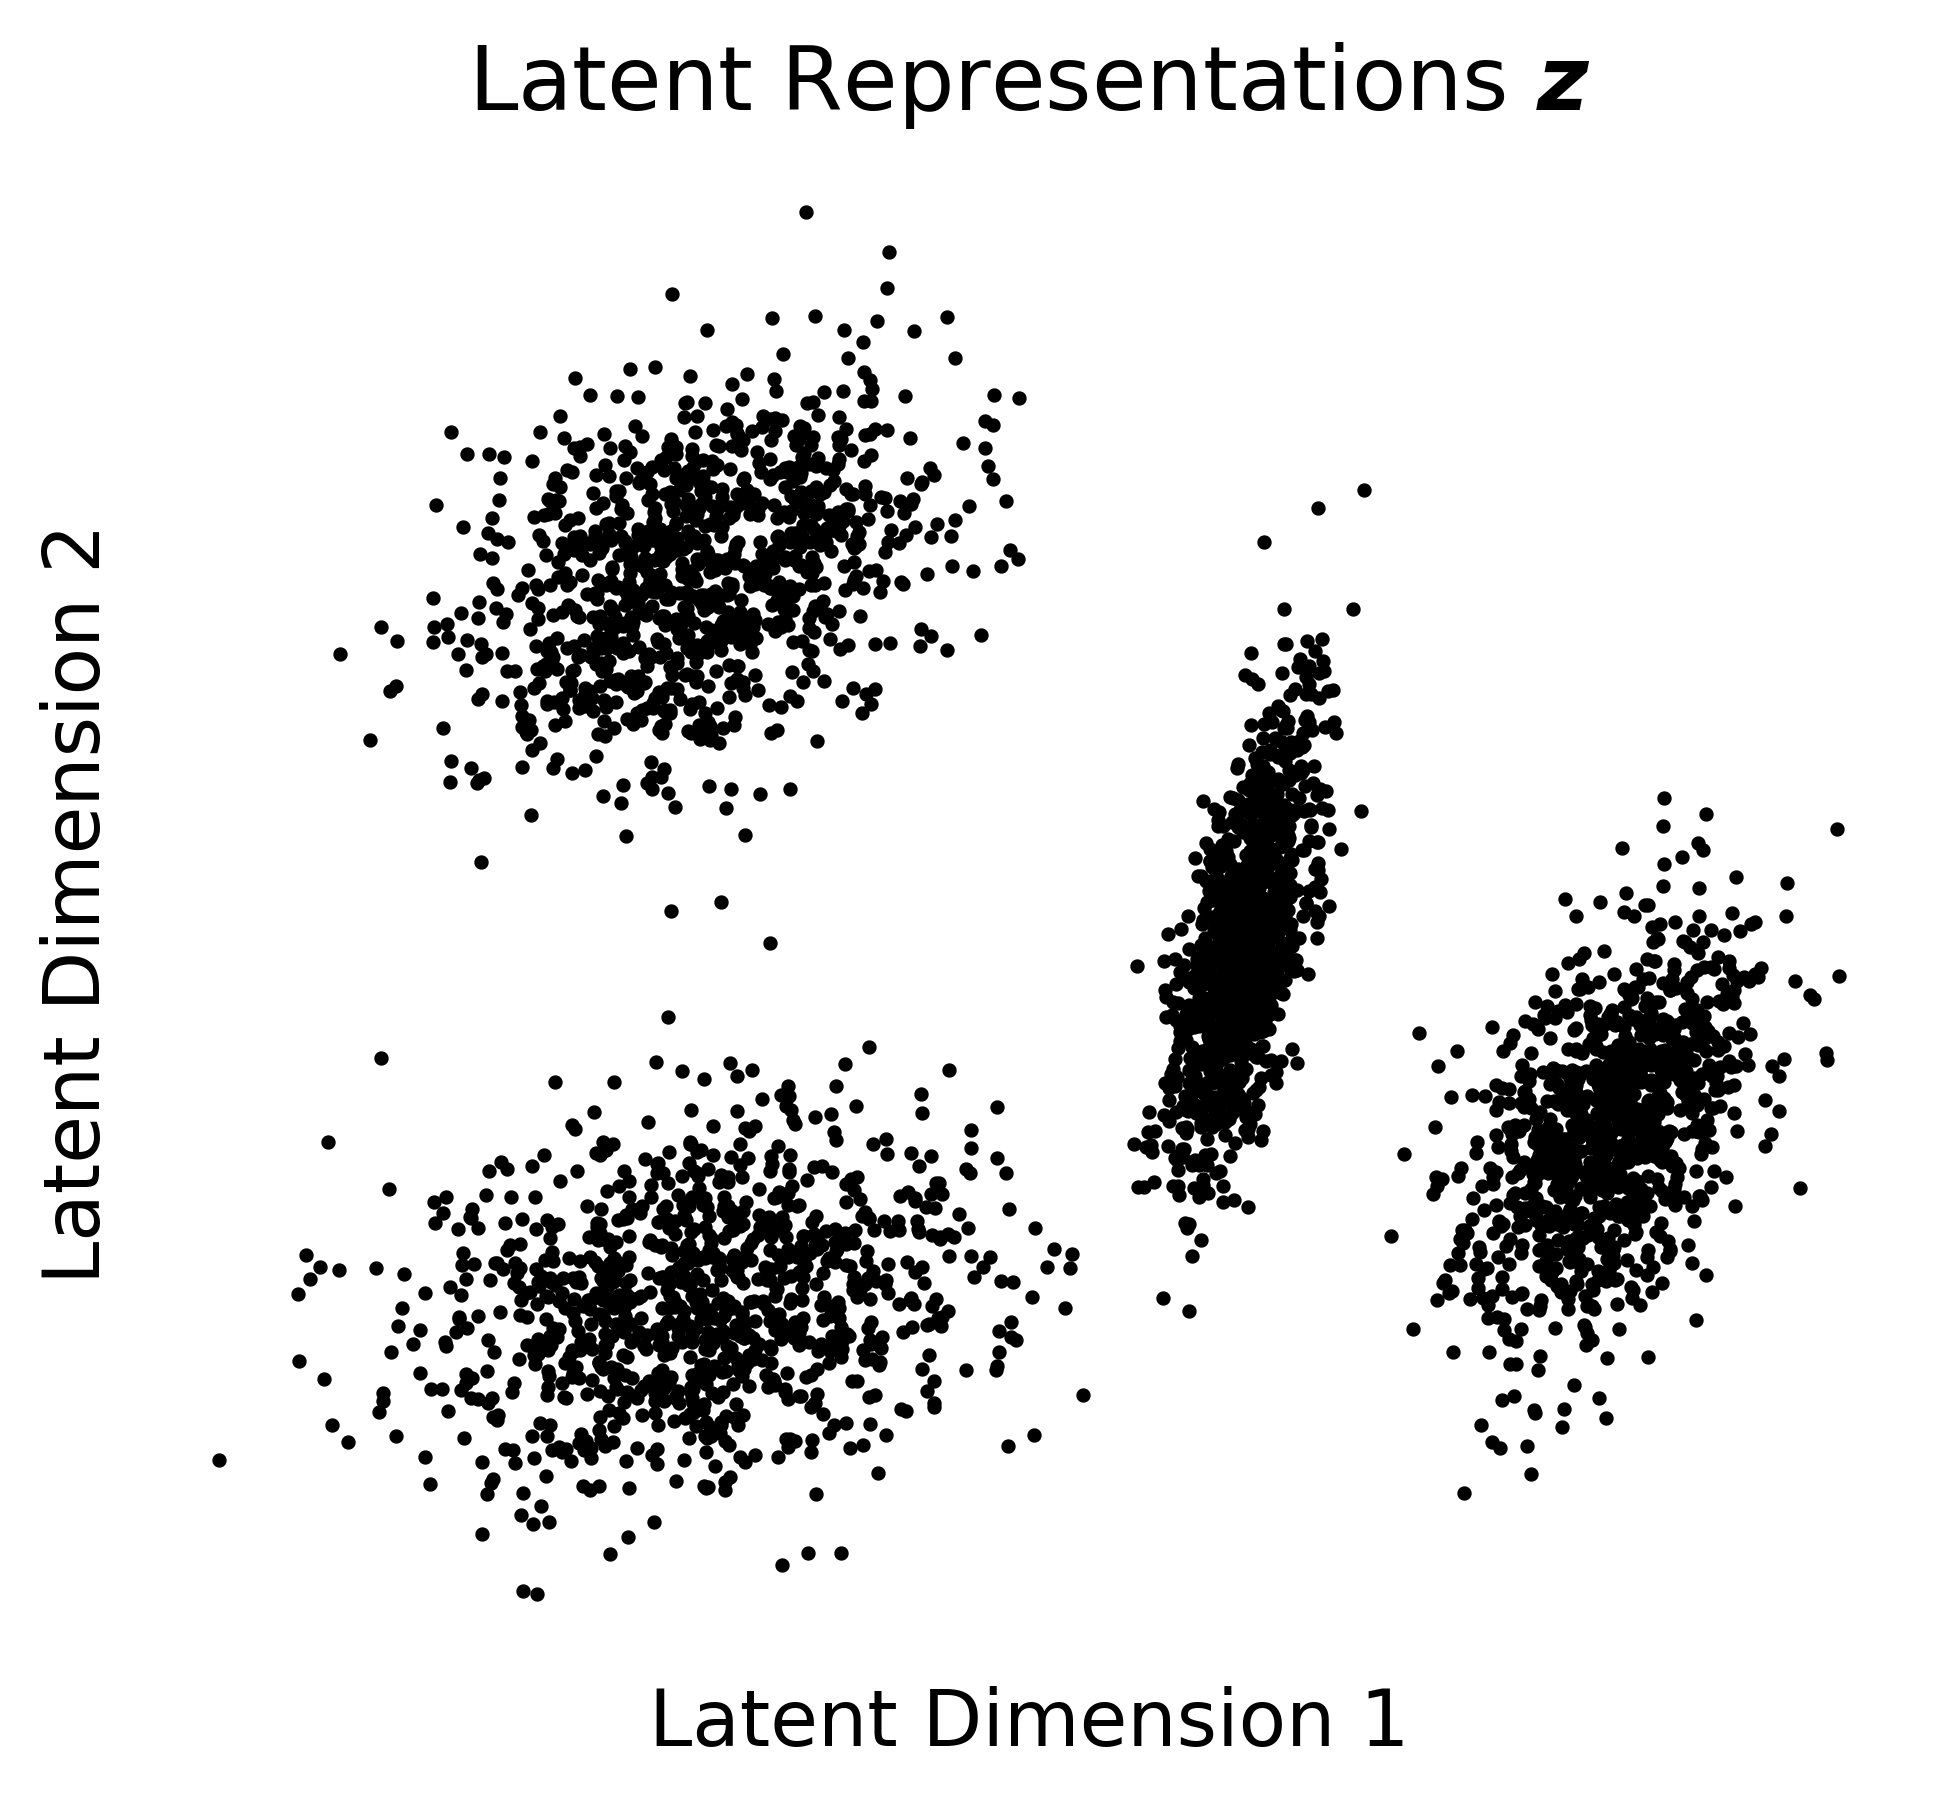

In [43]:
nrows, ncols = 1, 1
figsize = (5, 5)  # Square figure
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

plot_gmm(X=X, gmm=gmm, mode='dots', ax=ax, title=r'Latent Representations $\boldsymbol{z}$')

# Remove axes, ticks, and grid but keep labels
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_xticks([])
ax.set_yticks([])
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Make background transparent and set equal aspect ratio
fig.patch.set_alpha(0)  # Transparent figure background
ax.patch.set_alpha(0)   # Transparent axes background
ax.set_aspect('equal', adjustable='box')  # Equal aspect ratio

plt.tight_layout() 
plt.savefig('/home/asp/Downloads/HeaDS/TorchGMM/notebooks/latent_representations_dots.svg', 
            format='svg', bbox_inches='tight', dpi=300, transparent=True)
plt.show()

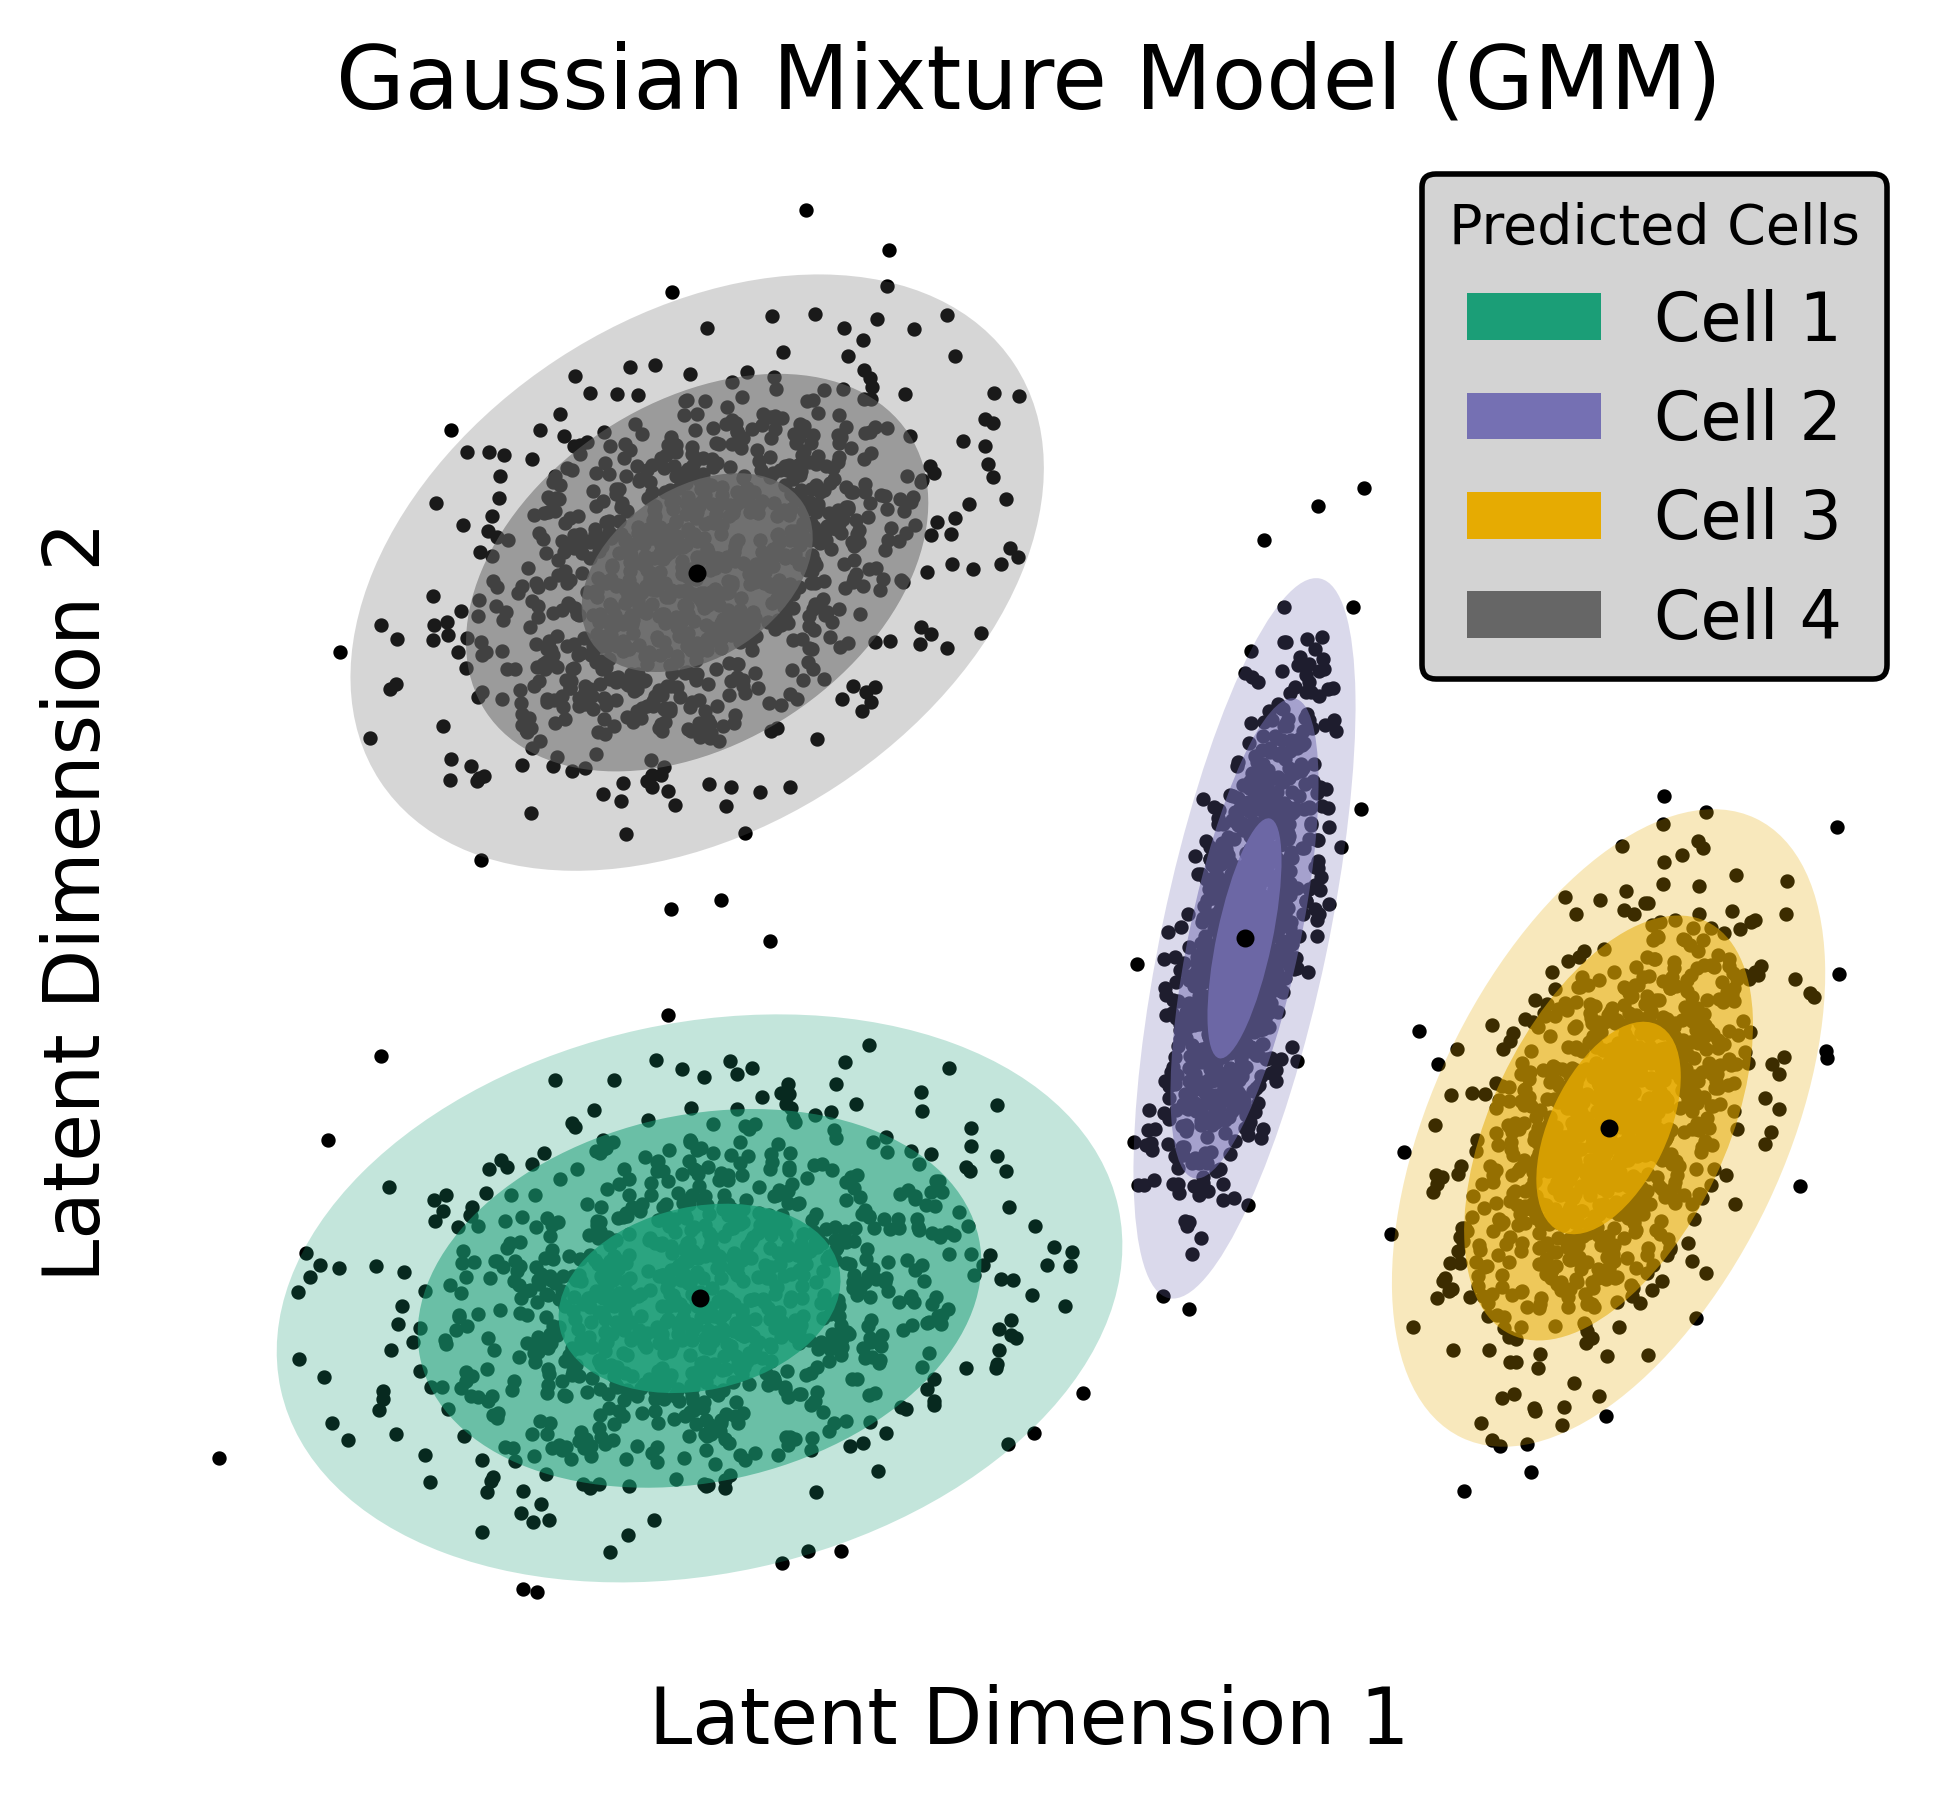

In [44]:
nrows, ncols = 1, 1
figsize = (5, 5)  # Square figure
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

plot_gmm(X=X, gmm=gmm, mode='ellipses', ax=ax, title='Gaussian Mixture Model (GMM)', legend_labels=['Cell 1', 'Cell 2', 'Cell 3', 'Cell 4'])

# Remove axes, ticks, and grid but keep labels
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_xticks([])
ax.set_yticks([])
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Make background transparent and set equal aspect ratio
fig.patch.set_alpha(0)  # Transparent figure background
ax.patch.set_alpha(0)   # Transparent axes background
ax.set_aspect('equal', adjustable='box')  # Equal aspect ratio

# Add legend for the ellipses
from matplotlib.patches import Patch

# Get the actual colors used by plot_gmm (Dark2 colormap)
import matplotlib.pyplot as plt
cmap = plt.get_cmap('Dark2')
colors = [cmap(i / (4 - 1)) for i in range(4)]  # This matches how plot_gmm generates colors

# Add custom legend with matching colors
from matplotlib.patches import Patch

legend_elements = [Patch(facecolor=colors[i], label=f'Cell {i+1}') for i in range(4)]
ax.legend(handles=legend_elements, loc='upper right', title='Predicted Cells')

plt.tight_layout() 
plt.savefig('/home/asp/Downloads/HeaDS/TorchGMM/notebooks/gaussian_mixture_model_ellipses.svg', 
            format='svg', bbox_inches='tight', dpi=300, transparent=True)
plt.show()

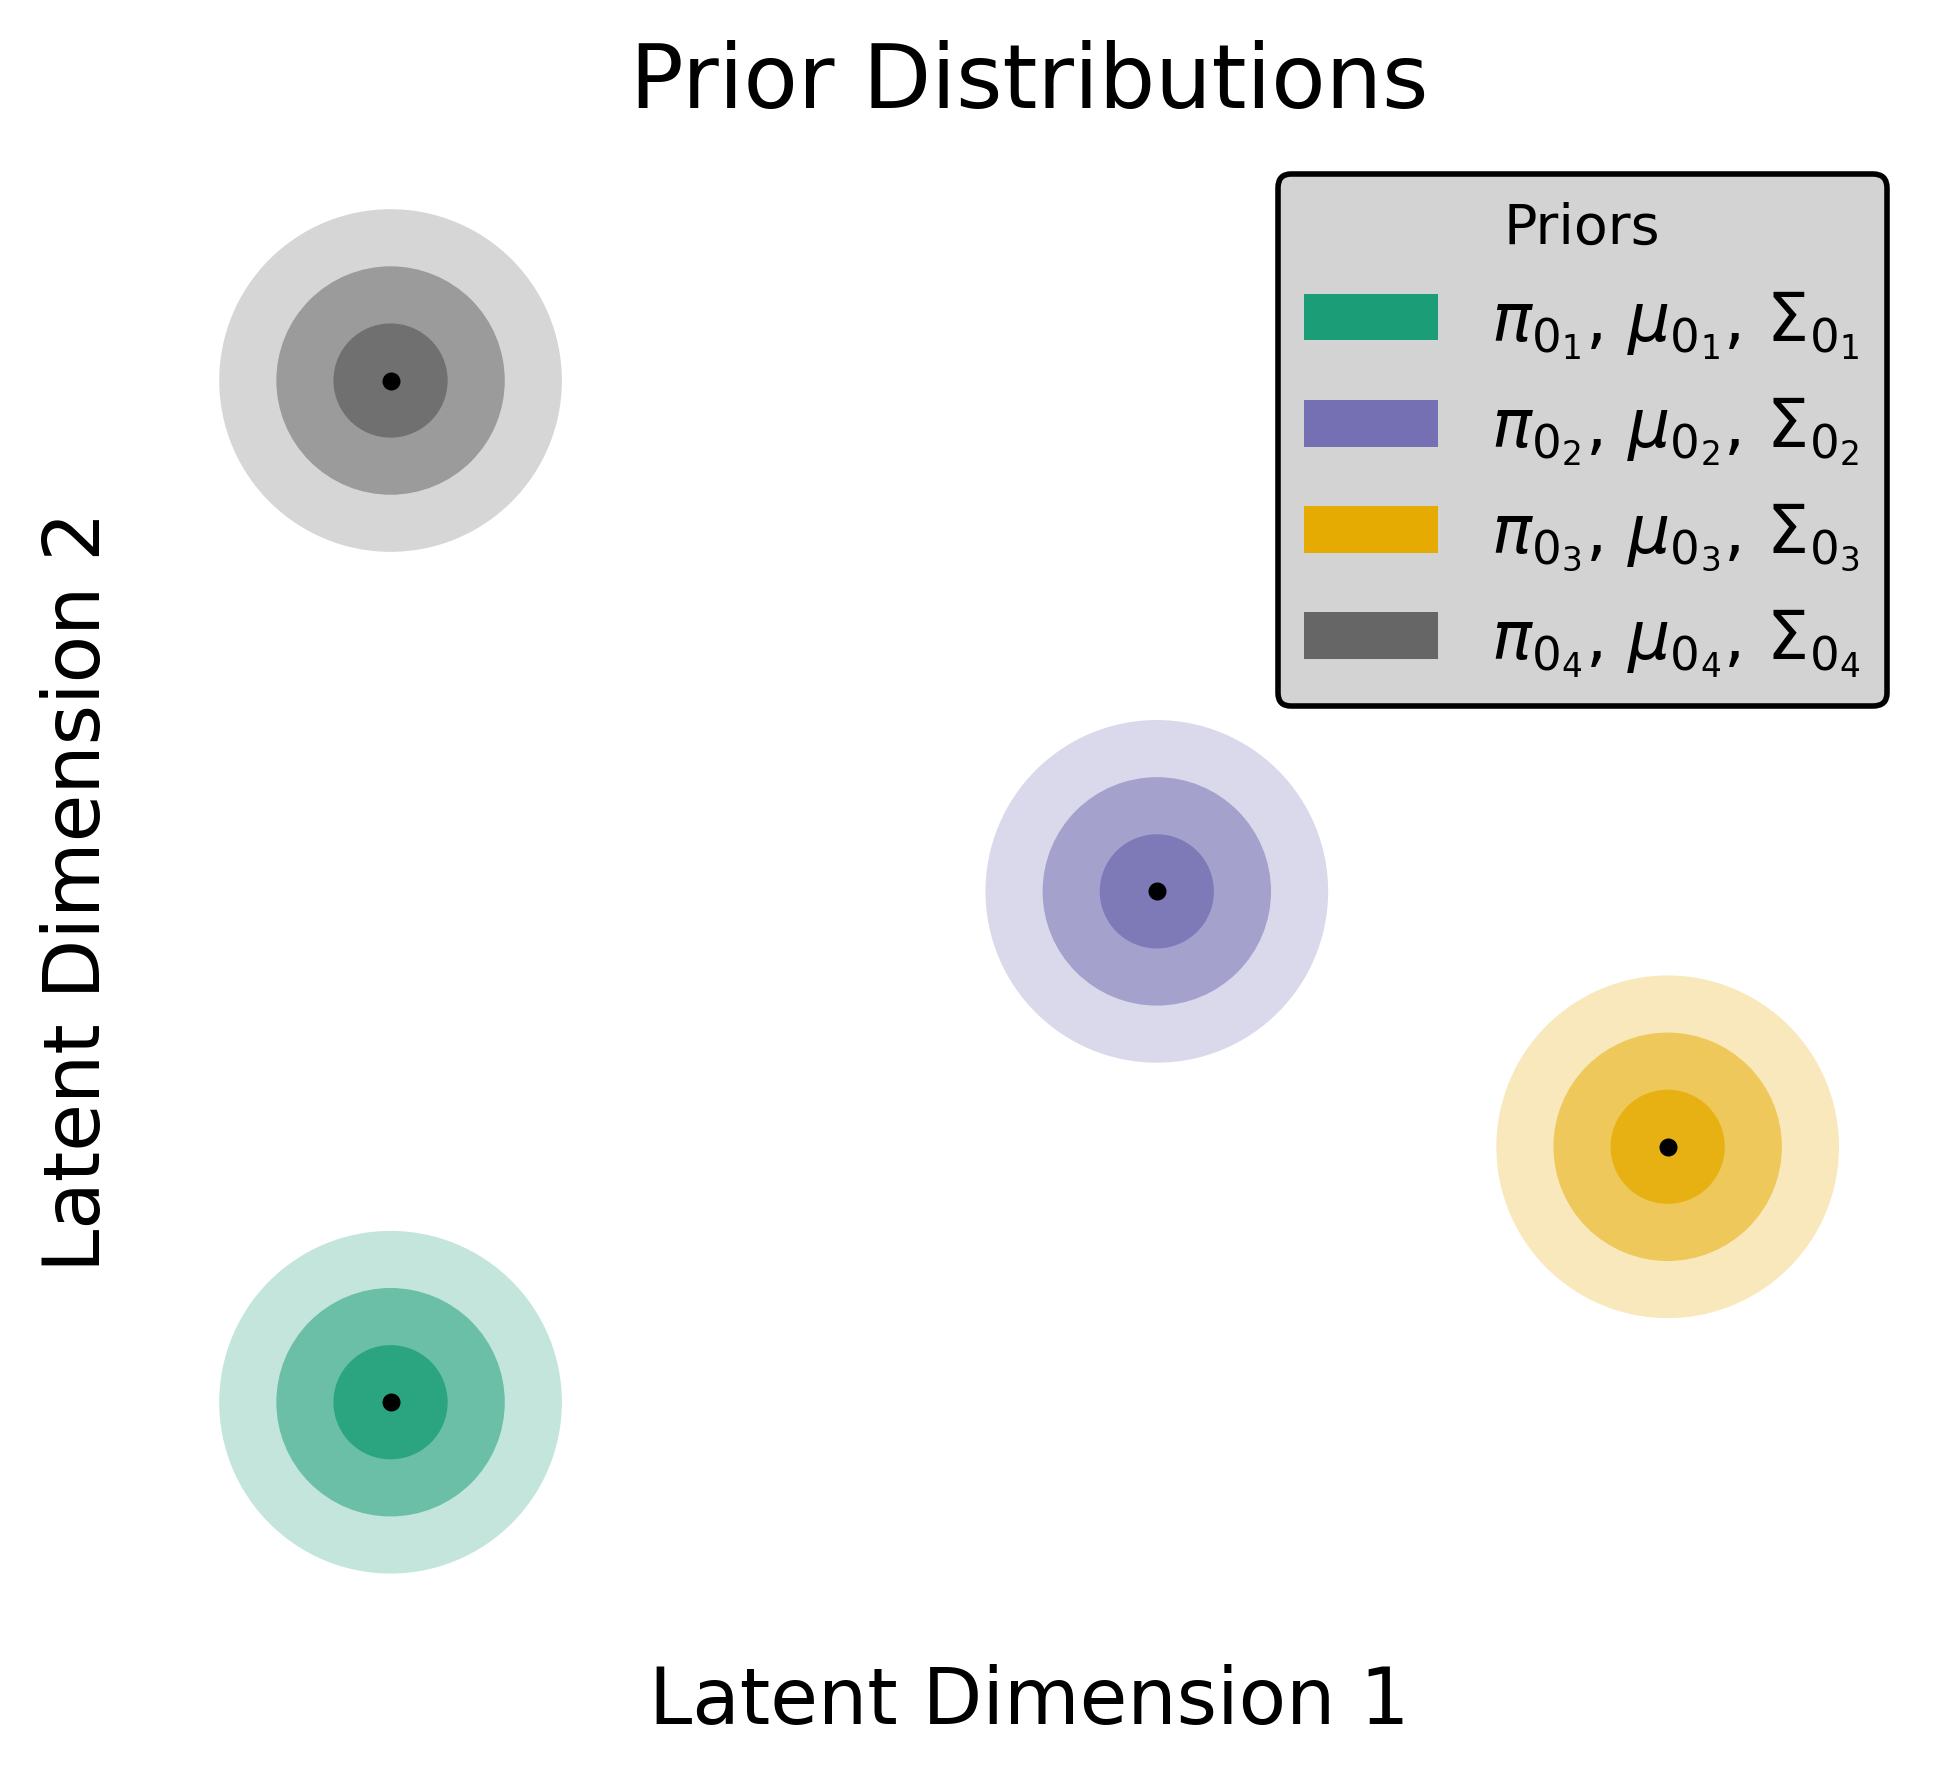

In [45]:
nrows, ncols = 1, 1
figsize = (5, 5)  # Square figure
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

# Create spherical covariances (0.2 * identity matrix)
spherical_covs = [0.05 * np.eye(2) for _ in range(4)]
weights = [0.25, 0.25, 0.25, 0.25]  # Equal weights

# Plot using the centers and spherical covariances
plot_gmm(X=np.empty((0, 2)), mode='ellipses', ax=ax, 
         weights=weights, means=centers, covariances=spherical_covs, 
         covariance_type='full', title='Prior Distributions')

# Remove axes, ticks, and grid but keep labels
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_xticks([])
ax.set_yticks([])
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Make background transparent and set equal aspect ratio
fig.patch.set_alpha(0)  # Transparent figure background
ax.patch.set_alpha(0)   # Transparent axes background
ax.set_aspect('equal', adjustable='box')  # Equal aspect ratio

# Get the actual colors used by plot_gmm (Dark2 colormap)
import matplotlib.pyplot as plt
cmap = plt.get_cmap('Dark2')
colors = [cmap(i / (4 - 1)) for i in range(4)]  # This matches how plot_gmm generates colors

# Add custom legend with matching colors
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors[i], label=rf'$\pi_{{0_{i+1}}}$, $\mu_{{0_{i+1}}}$, $\Sigma_{{0_{i+1}}}$') for i in range(4)]
ax.legend(handles=legend_elements, loc='upper right', title='Priors')

plt.tight_layout() 
plt.savefig('/home/asp/Downloads/HeaDS/TorchGMM/notebooks/priors_ellipses.svg', 
            format='svg', bbox_inches='tight', dpi=300, transparent=True)
plt.show()